## Cardiac MRF Workshop 2022

This notebook gives an overview how to simulate a MRF scan of the heart using a 2D Golden-radial data acquisition. We follow a top-down approach, i.e. here we will go through all the required steps by calling high-level functions. If you want to learn more about the details of each step, we will refer you to other notebooks. Below you can see an overview of the high-level functions:

<div>
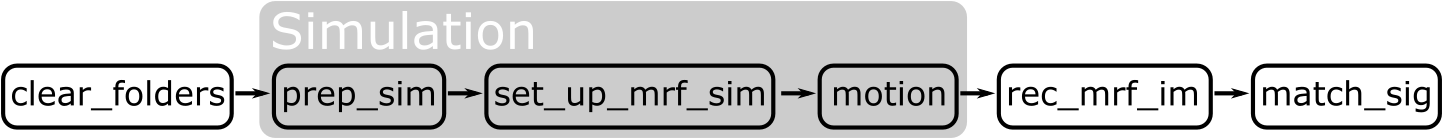
</div>


For the simulation we need:

- an MR rawdata file in ISMRMRD format describing the acquisition process (acquisition template)
- an anatomy segmentation in RAI format (right-anterior-inferior)
- an XML descriptor assigning tissue parameters to the labels.
- motion information (cardiac or respiratory) matching the anatomy segmentation
- contrast information describing the signal over time

We will go through the following steps:

#### A Clean up folders
To ensure there is nothing left from previous simulations we will clear everything.

#### B Prepare segmentation and motion fields
Load the segmentation and motion information and ensure all the geometric information is there. For more information have a look at the notebook **cMRF_Workshop2022-A**.

#### C Set up the simulation
Create a simulation object and add segmentation, MRF signal behaviour and information about the data acquisition. For more information have a look at the notebook **cMRF_Workshop2022-B**.

#### D Cardiac motion simulation
Add the cardiac motion fields to the simulation and provide a surrogate which describes the motion pattern during data acquisition. 

#### E Run the simulation
Run the simulation.

#### F Reconstruct image data
Reconstruct the dynamic image data. To speed up the reconstruction and improve image quality we combine a certain number of neighbouring radial lines to a single image.

#### G Carry out matching
Carry out matching between dynamic image data and a pre-calculated dictionary. 

In [ ]:
# Import required packages
import shutil, os
from pathlib import Path 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import subprocess 

import nibabel as nib
import numpy as np

import sirf.Reg as pReg
import sirf.DynamicSimulation as pDS
import sirf.Gadgetron as pMR
from cil.utilities.jupyter import islicer, link_islicer

import auxiliary_functions as aux
import cMRF_Workshop2022_helper as helper

In [ ]:
# Set main paths
root_path = Path('/home/sirfuser/devel/Data/SA/')
fpath_base = root_path / "Base"

# These folders will be filled with the formatted input 
# for the simulation and will then also contain the output of the simulation
fpath_in = root_path / "Input"
fpath_in.mkdir(exist_ok=True, parents=True)
fpath_out = root_path / "Output"
fpath_out.mkdir(exist_ok=True, parents=True)

In [ ]:
# Tissue parameters (T1, T2, Rho) : xml
fname_xml = fpath_base / 'XCat/XCAT_TissueParameters_XML.xml'
# 3D tissue segmentation : nifti
fpath_segmentation_nii = fpath_base / 'XCat/label_volume_sa.nii'
# Respiratory motion fields : nifti
fpath_resp_mvf = fpath_base / 'XCat/mvf_resp/'
# Cardiac motion fields : nifti
fpath_card_mvf = fpath_base / 'XCat/mvf_card/'

# MR raw k-space data file as acquisition template : ismrmrd
fname_acquisition_template = fpath_base / 'templates/acquisition_template.h5'

# MRF parameters used for EPG simulation
fname_epg_par = fpath_base / 'Fingerprinting/XCAT_tissue_parameter_list.npz'
# MRF signals describing signal behaviour of tissue types in segmentation simulated with EPG
fname_epg_sig = fpath_base / 'Fingerprinting/XCAT_tissue_parameter_fingerprints.npy'
# MRF dictionary for matching and parameter estimation
fname_dict = fpath_base / 'Fingerprinting/dict_70_1500.npz'

# Prefix for ground truth T1, T2 and rho maps
prefix_ground_truth = fpath_out / 'simulation_gt'

# Filename of simulated raw k-space data
fname_sim_out = fpath_out / 'output_sim.h5'


## A Clean up folders

When we set up the simulation, we need to save several files temporarily. To make sure we don't run into any problems from previous simulations, we go through all the folders and clean them. When you run the following cell you will be asked if you want to delete any old content. Just say 'y' to agree.

In [ ]:
# Set up folders for simulation (and remove exisiting ones)
helper.clear_folders([fpath_in, fpath_out])

## B Prepare segmentation and motion fields

Here we load the segmentation and cardiac/respiratory motion fields and ensure their geometric information is correct. We also select a smaller subset of slices to speed up the simulation. Everything is saved as standard nifti files in `fpath_in`. For more information have a look at the notebook **cMRF_Workshop2022-A**.

In [ ]:
fname_segmentation, fpath_card_mvf_out, fpath_resp_mvf_out = helper.prep_sim(fpath_segmentation_nii, fpath_resp_mvf, fpath_card_mvf, 
                                                                                   fpath_in, num_slices=10, slice_start=35)

## C Set up the simulation

To set up the simulation for MRF we use a prepared function which completes the following steps:

- load the segmentation into an `NiftiImageData3D` object
- load the precalculated MRF signals for all the tissues present in the simulation
- load a MR raw data file as a `AcquisitionData`
- create a `MRDynamicSimulation`
- add the segmentation to the simulation
- add the `AcquisitionData` as a template for the data acquisition to the simulation
- define the orientation/offset of the scan plane to be simulated
- define SNR
- define the coil sensitivity maps
- add the MRF signals as `ExternalMRContrastDynami`
    
For more information on each of these steps please have a look at the notebook **cMRF_Workshop2022_B**
    
The function retuns the 'MRDynamicSimulation' object **mrsim** and the temporal behaviour of the magnetisation for the tissue types of the segmentation **magnetisation**. 

In [ ]:
mrsim, magnetisation = helper.set_up_mrf_sim(fname_acquisition_template, fname_segmentation, fname_xml,
                                      fname_epg_par, fname_epg_sig, prefix_ground_truth, acq_step=10)

Let's check the shape of **magnetisation**

In [ ]:
print(f'The shape of magnetisation is {magnetisation.shape}')

There 78 different signals (one for each tissue type of the segmentation) and they cover 150 readouts (i.e. radial lines). What do the signals look like?

In [ ]:
# Visualise MRF signals
plt.figure()
plt.plot(np.real(magnetisation).transpose())
plt.xlabel('Readout number')
plt.ylabel('Signal (a.u.)');

## D Cardiac motion simulation

In order to simulate motion we need the following ingredients:

- motion vector fields
- a surrogate describing for each time point of the acquisition in which motion state we currently are
    
The motion vector fields we obtained from the XCAT simulation and are in `fpath_card_mvf_out`. The surrogate signal we have to create. Let's look at an ECG signal:

<div>
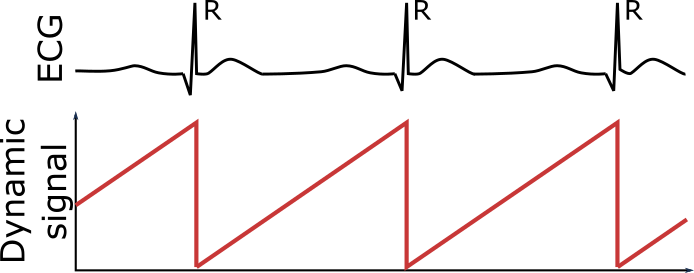
</div>


After each R-peak detected in the ECG, the cardiac motion states go from systole to diastole. To describe this we can use a saw-tooth function as our surrogate (`Dynamic signal`). In the code below we will create this surrogate for a specific heart rate and add it together with the motion vector fields to our simulation. The surrogate signal has to be normalised between 0 and 1. In the simulation the motion vector fields will then be interpolated to match the current value of the surrogate signal. E.g. if 4 motion vector fields are provided, and the current surrogate signal is 0.2 then the current motion transformation will be an interpolation of motion vector field 1 and 2. 

If we had a constant image contrast during our acquisition, the simulation would group all k-space data of a specific motion state and then carry out the simulation for all these k-space points together. For MRF, the MR signal changes for every readout and therefore we cannot group any k-space data for the motion simulation. This is just additional information, we don't have to do anything - the simulation is smart enough to figure all this out by itself. 

Let's start with the surrogate simulation

In [ ]:
# Simulation of cardiac motion

# Time axis = 12s
Nt = 10000
t0_s = 0
tmax_s = 12

# Frequency of heart beat
f_Hz_card = 1.25

# Create saw-tooth function
t_card, sig_card = aux.get_normed_sawtooth_signal(t0_s, tmax_s, Nt, f_Hz_card)

# Visualise surrogate signal
plt.figure()
plt.plot(t_card, sig_card)
plt.xlabel('Time (s)')
plt.ylabel('Motion surrogate');

In [ ]:
# This number does not matter since every readout get's its own motionstate
num_sim_card_states = 1
card_motion = pDS.MRMotionDynamic( num_sim_card_states )
card_motion.set_dynamic_signal(t_card, sig_card)
card_motion.set_cyclicality(False)
card_motion.set_groundtruth_folder_prefix(str(fpath_out / "gt_card_mrf/"))

aux.set_motionfields_from_path(card_motion, str(fpath_in / 'mvfs_card/'))
mrsim.add_motion_dynamic(card_motion)

## E Run the simulation

First we save the ground truth M0, T1 and T2 maps, then run the simulation and save the simulated raw data as `/home/sirfuser/devel/Data/SA/Output/output_sim.h5`. This is then also the end of the simulation part, and you could plug the simulated data into your favourite MRF image reconstruction + parameter estimation framework. But of course we also want to check here if the simulated data is actually any good and so we will do image reconstruction and dictionary matching afterwards.

In [ ]:
# Save ground truth parameter maps
filenames_parametermaps = mrsim.save_parametermap_ground_truth(str(prefix_ground_truth))

In [ ]:
# Simulate and save output
mrsim.simulate_data()
mrsim.write_simulation_results(str(fname_sim_out))

## F Reconstruct image data

We will carry out a basic image reconstruction by simply doing gridding of the radial data. We won't reconstruct one image per radial spoke but set the total number of reconstructed images with the paramter `num_recon_imgs`. The higher this values, the fewer radial lines per image are used and the more accurate the temporal behaviour of the MRF signal is recovered. But of course also the worse the quality of each image. More information on this can be found in **cMRF_Workshop2022_C**.

In [ ]:
# Reconstruct the dynamic image data
recon, simulated_data_dyn = helper.rec_mrf_im(fname_sim_out, num_recon_imgs=30)

In [ ]:
recon_result = recon.as_array()
recon_result = np.abs(recon_result)

## G Carry out matching

Finally we carry out dictionary matching with a pre-calculated dictionary, visualise the obtained maps and compare them to the ground truth maps. More information on this can be found in **cMRF_Workshop2022_C**.

In [ ]:
m0_t1_t2_map_matched = helper.match_sig(recon, simulated_data_dyn, fname_dict, acq_step=10)

In [ ]:
print(m0_t1_t2_map_matched.shape)

In [ ]:
helper.vis_m0_t1_t2_mrf_maps([m0_t1_t2_map_matched,])

Now we can also load the ground truth maps to compare

In [ ]:
m0_t1_t2_map_gt = helper.load_gt_maps(filenames_parametermaps)

In [ ]:
helper.vis_m0_t1_t2_mrf_maps([m0_t1_t2_map_gt, m0_t1_t2_map_matched,], method_titles=['Ground truth', 'Motion'])

## Recap and outlook

Well done! You now went through all the steps of setting up the simulation, defining a motion pattern and surrogate, carrying out the simulation, reconstruction the images and doing the dictionary matching to obtain the final parameter maps. 

To check that you understood this notebook you can try the following challenges:

- Define the cardiac motion surrogate in a way such that all the data is acquired in systole
- Add respiratory motion to the simulation and simulate a scan, where the patient cannot hold their breath a the same position during the scans but shows a drift

The solutions you can find in **cMRF_Workshop2022-systole** and **cMRF_Workshop2022-drift**, but please try it yourself before you check them out. 

You can also have a look at notebooks **cMRF_Workshop2022-A**, **cMRF_Workshop2022-B** and **cMRF_Workshop2022_C** to learn more about the high-level functions used in this notebook. 